The purpose of this problem is to determine the inverse kinematics of a manipulator with the method of Decomposition and Approximation

The general approach is to fuzz the forward kinematic equations for the workspace with random input angles, split the output coordinates into subgrids, then for each subgrid, we attempt to create a regression that correlates the output corrdinates to input angles (inverse kinematics) for each grid. 

Now the grid of regressions becomes a table lookup when doing inverse kinematics; find the subgrid that corresponds to the output corrdinates and use the grid's regression to compute the input angles.

Notebook can be viewed and downloaded from https://github.com/colanzio5/SDSU-CS556-Workspace/tree/master/a3

In [1]:
# packages
import math
import random
import matplotlib
import tinyik
import numpy as np
import sympy as sp
import pandas as pd
from sympy.solvers import solve
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.vector import init_vprinting
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# configure pretty latex like printing
init_vprinting(use_latex="mathjax", pretty_print=False)

# number of random input angles
# to fuzz into the forward kinematics
# equations for approximation
NUMBER_TRIALS = 50000

# link lengths (in centimeters)
L1_LENGTH = 100
L2_LENGTH = 100

# the resolution for our
# our grid space approximation
NUMBER_ROWS = 50
NUMBER_COLS = 50

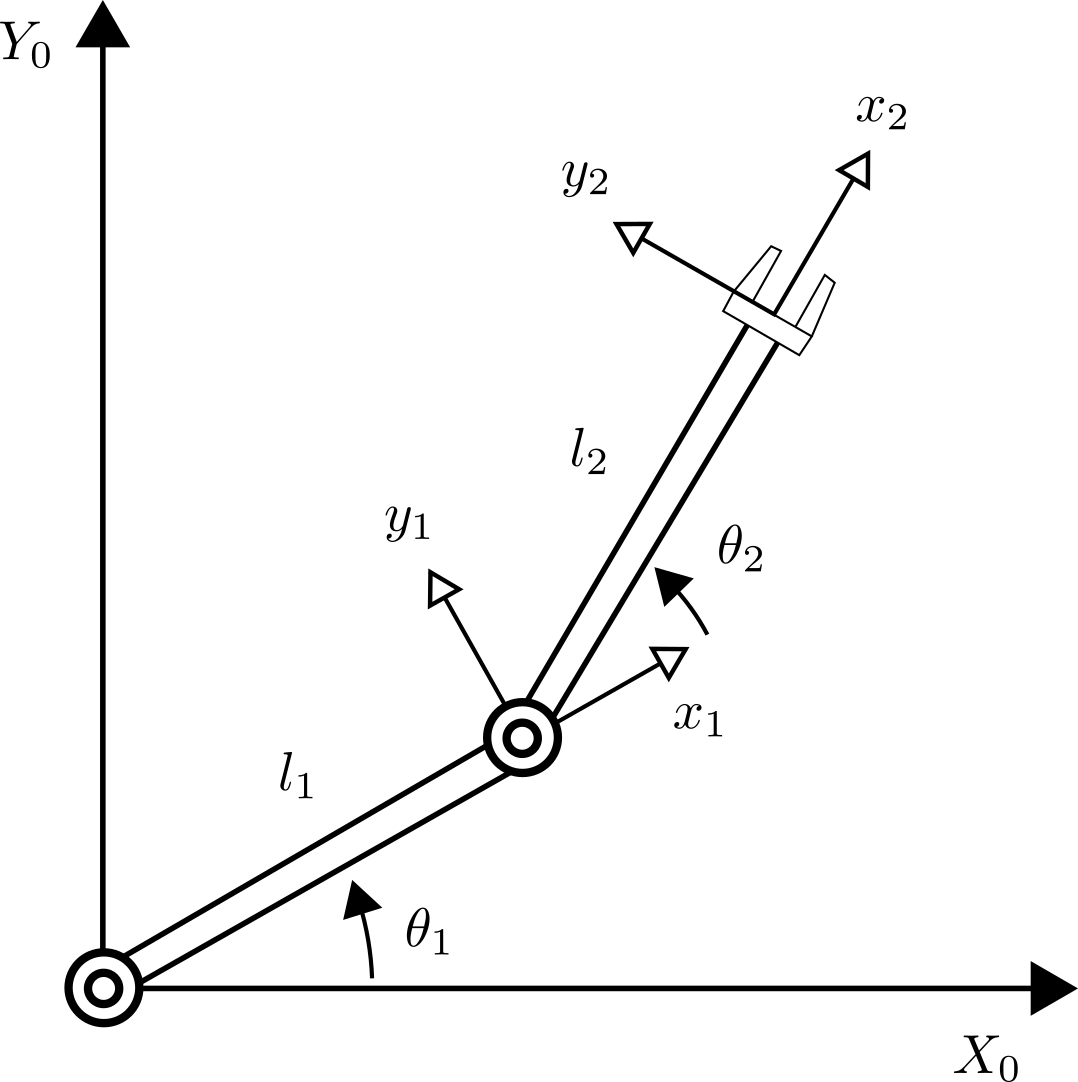

In [2]:
# here's an image of the robot arm in question
from IPython.display import Image
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
Image("./fig/img1.png", width=300)

In [3]:
"""
Derive the forward kinematics equations to find the 
corresponding x,y coordnates based on given (θ1, θ2) 
pair for the 2PR manipulator
"""

# declare the symbolic variables
# we'll need to do linear algebra
theta1, theta2, l1, l2, theta, alpha, a, d = dynamicsymbols(
    "theta1 theta2 l1 l2 theta alpha a d"
)

# rotation matrix based off
# of our dh table
rotation_matrix = sp.Matrix(
    [
        [sp.cos(theta), -sp.sin(theta) * sp.cos(alpha), sp.sin(theta) * sp.sin(alpha)],
        [sp.sin(theta), sp.cos(theta) * sp.cos(alpha), -sp.cos(theta) * sp.sin(alpha)],
        [0, sp.sin(alpha), sp.cos(alpha)],
    ]
)

# x,y,z transformation matrix
transformation_matrix = sp.Matrix([a * sp.cos(theta), a * sp.sin(theta), d])

# the definition for the last row
# in a homogenous transformation matrix
last_row = sp.Matrix([[0, 0, 0, 1]])

# combine the rotation, transformation and last row
# to get homogenous transformation matrix
t = sp.Matrix.vstack(sp.Matrix.hstack(rotation_matrix, transformation_matrix), last_row)

# given the homogenous transformation matrix
# we need to find the transformation from
# frame 0 to frame 2
t_02 = t.subs({alpha: 0, a: l1, theta: theta1, d: 0}) * t.subs(
    {alpha: 0, a: l2, theta: theta2, d: 0}
)

t_02.simplify()
display(t_02)

Matrix([
[cos(theta1 + theta2), -sin(theta1 + theta2), 0, l1*cos(theta1) + l2*cos(theta1 + theta2)],
[sin(theta1 + theta2),  cos(theta1 + theta2), 0, l1*sin(theta1) + l2*sin(theta1 + theta2)],
[                   0,                     0, 1,                                        0],
[                   0,                     0, 0,                                        1]])

In [4]:
# give our transformation matrix
# we can derive forward kinematics
# for example
x_position = t_02[0, 3]
y_position = t_02[1, 3]
fk_x = sp.lambdify((l1, l2, theta1, theta2), x_position, "numpy")
fk_y = sp.lambdify((l1, l2, theta1, theta2), y_position, "numpy")

def RR_forward_kinematics(theta1, theta2):
    """
        inverse kinematics for our 2PR robot
        given joint angles theta1 and theta2
        returns the x and y positions of the 
        end effector
    """
    return (
        fk_x(L1_LENGTH, L2_LENGTH, theta1, theta2),
        fk_y(L1_LENGTH, L2_LENGTH, theta1, theta2),
    )


def RR_inverse_kinematics(x, y):
    """
        forward kinematics for our 2PR robot
        given a desired x any y coordinate 
        returns both joint angles for the arm
        https://pythonrobotics.readthedocs.io/en/latest/modules/arm_navigation.html
    """
    try:
        # calculate both solutions for
        # theta 2
        a = x ** 2 + y ** 2 - L1_LENGTH ** 2 - L2_LENGTH ** 2
        b = 2 * L1_LENGTH * L2_LENGTH
        theta2_positive = math.acos((a / b))
        theta2_negative = -1 * theta2_positive

        # calculate both solutions for theta2
        theta1_positive = math.atan2(y, x) - math.atan2(
            L1_LENGTH * math.sin(theta2_positive),
            L1_LENGTH + L2_LENGTH * math.cos(theta2_positive),
        )
        theta1_negative = math.atan2(y, x) - math.atan2(
            L1_LENGTH * math.sin(theta2_negative),
            L1_LENGTH + L2_LENGTH * math.cos(theta2_negative),
        )
        return [(theta1_positive, theta2_positive), (theta1_negative, theta2_negative)]

    # an error is thrown when this function trys to
    # calculate the inverse kinematics for a position
    # outside the workspace of the 2PR arm
    except ValueError as e:
        return None

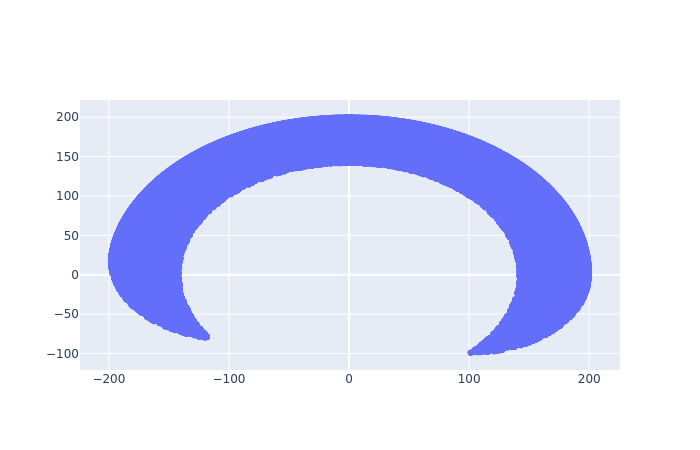

In [6]:
"""
Generate NUMBER_TRIALS random (θ1, θ2) pairs, 
and  use the forward kinematics equations to find the 
corresponding  points in workspace. Keeps a record of 
points in each cell.
"""
# map the forward kinematics
# equations onto the input set
trial_points = [
    {
        "input_angles": input_angles, 
        "forward_kinematics": RR_forward_kinematics(*input_angles)
    } for input_angles in [
        (
            np.deg2rad(random.uniform(0, 170)),
            np.deg2rad(random.uniform(-90, 90))
        ) for x in range(NUMBER_TRIALS)
    ]
]

# plot the fuzzed forward
# kinematics to show our workspace
x_cord = [ e['forward_kinematics'][0] for e in trial_points ]
y_cord = [ e['forward_kinematics'][1] for e in trial_points ]
go.Figure(
    data=go.Scattergl(
        x = x_cord,
        y = y_cord,
        mode='markers'
    )
).show(renderer="png")

In [ ]:
# helper variables for
# our workspace frame
x_min = math.floor(min(x_cord))
y_min = math.floor(min(y_cord))
x_max = math.ceil(max(x_cord))
y_max = math.ceil(max(y_cord))
workspace_width = x_max - x_min
workspace_height = y_max - y_min

# helper variables for our
# grid representation
cell_width = workspace_width / NUMBER_COLS
grid_width = math.ceil(workspace_width / cell_width)
cell_height = workspace_height / NUMBER_ROWS
grid_height = math.ceil(workspace_height / cell_height)

# helper function to map x,y position
# vector to matching grid coordinates
def get_grid_coordinates(x, y):
    _x = math.floor(((x - x_min) / workspace_width) * grid_width)
    _y = math.floor(((y - y_min) / workspace_height) * grid_height)
    return _x, _y

In [ ]:
"""
Divide the joint and workspace in into square cells. 

You will need to decide on the size of the cells in the 
joint space and work space, for example x=y=10 cm.
"""
# first set up a grid of points
# so we can determine how to group
# results from forward kinematics
grid_points = [[[] for x in range(grid_width)] for y in range(grid_height)]

# for each generated forward kinematics
# output coordinate, we need to find it's
# position in the grid and put in the grid
# array we made previously
for point in trial_points:
    input_angles = (point["input_angles"][0], point["input_angles"][1])
    forward_kinematics = (point["forward_kinematics"][0], point["forward_kinematics"][1])
    x_cord, y_cord = get_grid_coordinates(*forward_kinematics)
    grid_points[y_cord][x_cord].append(point)

In [ ]:
# some helper objects for the chart
# we're about to make, dictionary of
# colors we can randomly select from
hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []
for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)

"""
show how we've split the workspace into grid
sections. each colored, square cluster
of points share the same grid coordinates
"""
grid_plot = go.Figure()
for y_index, row in enumerate(grid_points):
    for x_index, cell in enumerate(row):
        # if the cell has no
        # points, do nothing
        if len(cell) == 0:
            continue
        # plot the x,y pairs
        # for this cell
        grid_plot.add_trace(
            go.Scattergl(
                x=[ e['forward_kinematics'][0] for e in cell ],
                y=[ e['forward_kinematics'][1] for e in cell ],
                mode="markers",
                fillcolor=random.choice(hex_colors_only),
                name="(" + str(x_index) + "," + str(y_index) + ")",
            )
        )
# show the plot
grid_plot.show(renderer="png")

In [ ]:
"""
Using k-mean clustering, divide the points 
in each cell into two clusters, representing  
the two solutions.
"""

# now lets turn the output grid
# into a data frame for easier
# analysis of our approximation
grid_df = pd.DataFrame(e for e in grid_points)

# helper function to find
# k_means clusters for each
# cell of the dataframe
# and split coordinates in cell
# into groups based on k_means cluster
def k_means_split(cell):
    
    # if the cell doesn't have at 
    # least 2 points, we can't 
    # do a kmeans cluster
    if len(cell) < 2:
        return None
    
    # make t1 and t2 lists and
    # pair them for kmeans inputs
    t1_list = [ e['input_angles'][0] for e in cell ]
    t2_list = [ e['input_angles'][1] for e in cell ]
    t1_t2_pairs = list(zip(t1_list, t2_list))

    # create the kmeans model
    kmeans = KMeans(n_clusters=2)
    cluster_indexes = kmeans.fit_predict(t1_t2_pairs)

    # group the points by cluster
    return [
        [e for i, e in enumerate(cell) if cluster_indexes[i] == 0],
        [e for i, e in enumerate(cell) if cluster_indexes[i] == 1],
    ]

# apply the function to split
# each cell into two clusters
cluster_grid_df = grid_df.applymap(k_means_split)

In [ ]:
"""
In each cell and each cluster in the cell, 
approximate the inverse kinematics by 
linear relationship of the form

x=ai1+bi2+ci;    x=di1+ei2+fi;

where i=1,2, ..., n are the cell numbers, 
and the coefficients ai to fi are found 
using regression (curve fitting).

Store the coefficients. This completes 
the decomposition and approximation.
"""


def lin_reg(cell):
    
    # if there aren't any points
    # in the cell, do nothing
    if cell == None:
        return None
    
    # helper function to 
    # find the linear regression
    # for one cluster in the cell
    def _lin_reg_helper(cluster):
        x_list = [ e['forward_kinematics'][0] for e in cluster ]
        y_list = [ e['forward_kinematics'][1] for e in cluster ]
        x_y_pairs = list(zip(x_list, y_list))
        t1_list = [ e['input_angles'][0] for e in cluster ]
        t2_list = [ e['input_angles'][1] for e in cluster ]
        t1_t2_pairs = list(zip(t1_list, t2_list))
        return LinearRegression().fit(x_y_pairs, t1_t2_pairs)

    # call the helper function for 
    # each cluster in the cell
    return [_lin_reg_helper(cluster) for cluster in cell]


lin_reg_cluster_grid = cluster_grid_df.applymap(lin_reg)

In [ ]:
"""
Given a set of 100 position (x,y) points 
find the corresponding two solution (θ1, θ2) pairs 
for each position.
"""

trial_errors = []
predicted_solutions = []
inputs = []

while len(trial_errors) < 1000:
    # generate some random input positions
    # NOTE: these aren't guaranteed to be within
    # the workspace of the robot.
    px, py = random.uniform(x_min, x_max), random.uniform(y_min, y_max)

    # get the grid coordinates
    # for the regression lookup
    x, y = get_grid_coordinates(px, py)
    ik = RR_inverse_kinematics(px, py)

    # don't do anything if there's nothing in the cell
    # or if the inverse kinematics returns None
    if lin_reg_cluster_grid[x][y] is None or ik is None:
        continue
        
    # save the inputs and actual 
    # inverse kinematics
    inputs.append((px,py))

    # get the inverse kinematic solutions
    # based of the cluster linear regressions
    c1, c2 = lin_reg_cluster_grid[x][y]

    # using the two linear regression objects
    # for each cell, pridict the two inverse
    # kinematic solutions for the given coordinates
    solution_1 = c1.predict([[px, py]])[-1]
    solution_2 = c2.predict([[px, py]])[-1]

    # given the predictetd solutions, see where
    # the arm would go if we used these input angles
    solution1_fk = RR_forward_kinematics(*solution_1)
    solution2_fk = RR_forward_kinematics(*solution_2)

    # helper function for finding the
    # distance between two numbers when
    # we don't know which is larger
    def distance(a, b):
        if (a < 0) and (b < 0) or (a > 0) and (b > 0):
            return abs(abs(a) - abs(b))
        if (a < 0) and (b > 0) or (a > 0) and (b < 0):
            return abs(abs(a) + abs(b))

    # determine the total error in our approximation
    # by finding the distance between the actual point and
    # the two points predicted by linear approximation
    solution_1_error = abs(math.hypot(px - solution1_fk[0], py - solution1_fk[1]))
    solution_2_error = abs(math.hypot(px - solution2_fk[0], py - solution2_fk[1]))
    
    # depending on which solution
    # is more accurate, add the most
    # accurate soluton's error to the 
    # array of trial errors
    if(solution_1_error <= solution_2_error):
        predicted_solutions.append(solution1_fk)
        trial_errors.append(solution_1_error)
    else: 
        predicted_solutions.append(solution2_fk)
        trial_errors.append(solution_2_error)

# take the average of all of the
# total errors for each trial
average_error = sum(trial_errors) / len(trial_errors)
print("average error: ", average_error, " cm")

In [ ]:
"""
here's a chart showing the inputs to
out test above on the x y plane

each datapoint's size and color
coresponds to the amount of error encountered
during our approximation step, where
smaller, darker datapoints are more accurate
and larger lighter datapoints have more error

Note: sizes and colors of data points 
in the scatter plot are not to scale 
in terms of the approximation error. 
Only for a relative scale.
"""
x_inputs = list(map(lambda x: x[0], inputs))
y_inputs = list(map(lambda x: x[1], inputs))
normalized_error = [ (x+5) for x in trial_errors]

error_chart = go.Figure(
    data=go.Scattergl(
        x = x_inputs,
        y = y_inputs,
        mode='markers',
        marker=dict(
            size=normalized_error,
            color=trial_errors,
            colorscale='Viridis'
        )
    )
)
error_chart.show(renderer="png")